# Integrating the Bloch Hamiltonian

## Adiabatic Bragg pulse

First lets simulate the adiabatic Bragg pulse from [Adiabatic-rapid-passage multiphoton Bragg atom optics](https://doi.org/10.1103/PhysRevA.86.011606) by Kovachy.

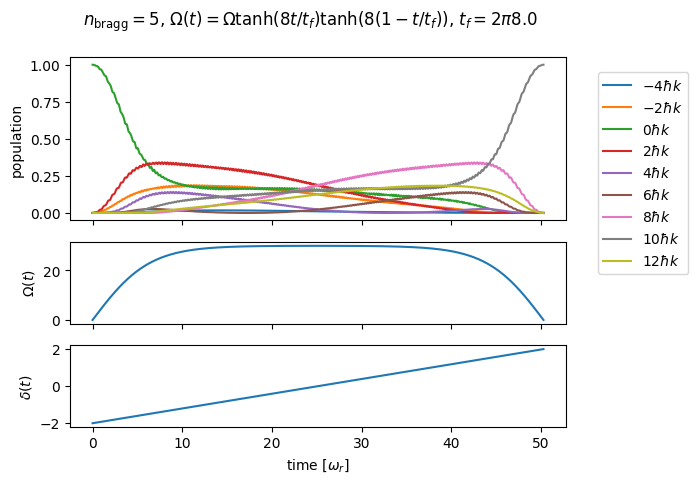

In [1]:
from mwave.integrate import bloch, make_kvec, make_phi
from numba import jit
import numpy as np
from matplotlib import pyplot as plt

# Define pulse parameters
n0, nf = 0, 5
omega = 30
delta = 4*(n0 + nf)

# Compute tfinal and t0 from sigma
tfinal = 8*2*np.pi
t0 = tfinal/2

# Compute detuning ramp rate as 2*omega_r/(tfinal/2)
rate = 2/(tfinal/2)

# Define pulse profile used in Kovachy (2012)
@jit(nopython=True)
def omega_fnc(t, args):
    omega = args[0]
    return omega*np.tanh(8*t/tfinal)*np.tanh(8*(1 - t/tfinal))

# Define the phase used in Kovachy (2012)
@jit(nopython=True)
def phase_fnc(t, args):
    tcurrent = (t-tfinal/2)
    return rate/2*(tcurrent**2) # The phase is the integral of the time dependent frequency over time

# Write out a function for the detuning vs time
def delta_fnc(t):
    tcurrent = (t-tfinal/2)
    return rate*tcurrent

# Define the initial state and the kvec array
kvec, n0_idx, nf_idx = make_kvec(n0, nf)
phi0 = make_phi(kvec, n0)

# Integrate the pulse
sol = bloch(kvec, phi0, tfinal, delta, omega_fnc, np.array([omega]), phase_fnc, np.array([]))

# Determine the minimum and maximum indicies
n_max = max(n0_idx, nf_idx)
n_min = min(n0_idx, nf_idx)

# Plot
fig, [ax1, ax2, ax3] = plt.subplots(nrows = 3, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
ax1.plot(sol.t, np.abs(sol.y.T[:,n_min-2:n_max+2])**2, label=[r"$%i\hbar k$" % k for k in kvec[n_min-2:n_max+2]])
ax2.plot(sol.t, [omega_fnc(t, np.array([omega])) for t in sol.t])
ax3.plot(sol.t, [delta_fnc(t) for t in sol.t])
ax1.legend(bbox_to_anchor=(1.05, 0.95))
ax1.set_ylabel(r'population')
ax2.set_ylabel(r'$\Omega(t)$')
ax3.set_ylabel(r'$\delta(t)$')
ax3.set_xlabel(r'time [$\omega_r$]')
fig.suptitle(r'$n_\text{bragg}=5$, $\Omega(t)=\Omega\tanh(8t/t_f)\tanh(8(1-t/t_f))$, $t_f=2\pi %0.1f$' % (tfinal/2/np.pi))
plt.show()

The two lower subplots are equivalent to Fig. 1a and b from the paper.

Next lets replicate Fig. 2a

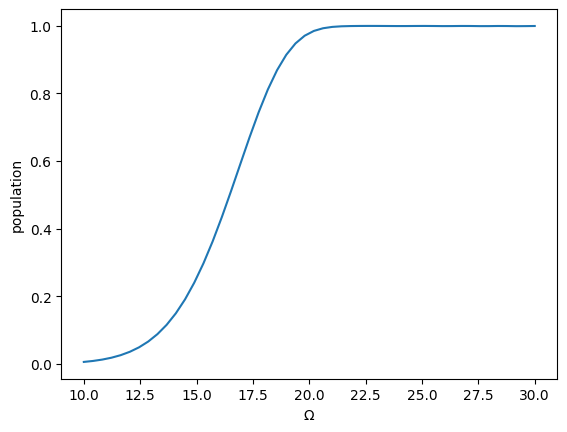

In [2]:
# Define a function to compute the population in the final state as a function of the drive
fpop = lambda omega: np.abs(bloch(kvec, phi0, tfinal, delta, omega_fnc, np.array([omega]), phase_fnc, np.array([]), atol=1e-6, rtol=1e-6).y[nf_idx,-1])**2

# Compute along an array of omega values
omegas = np.linspace(10,30)
pops = np.full_like(omegas, np.nan)
for i in range(len(omegas)):
    pops[i] = fpop(omegas[i])

# Plot
fig, ax1 = plt.subplots()
ax1.plot(omegas, pops)
ax1.set_ylabel(r'population')
ax1.set_xlabel(r'$\Omega$')
plt.show()

## Bloch oscillations

The lattice velocity should initially be that of the atoms and should be swept at rate $\alpha$ until the lattice velocity reaches our target velocity. Mathematically this works out to be
$$\delta_0=8n_0\omega_r$$
$$\delta(t)=\delta_0+\alpha t$$
$$\delta_f=8n_f\omega_r$$
(See my Bloch oscillations GoodNotes for the reasoning behind this.)

The phase of the drive is therefore
$$\theta(t)=\delta_0t+\frac{1}{2}\alpha t^2$$
The sweep should be stopped at
$$t_f=(\delta_f-\delta_0)/\alpha=8(n_f-n_0)\omega_r/\alpha$$
Lets try this out with fifth order Bloch

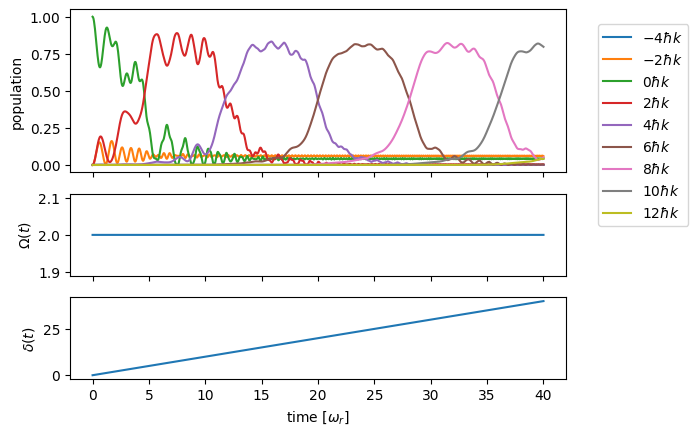

In [1]:
from mwave.integrate import bloch, make_kvec, make_phi
from numba import jit
import numpy as np
from matplotlib import pyplot as plt

# Define pulse parameters
n0, nf = 0, 5
omega = 2
alpha = 1

# Compute parameters
delta0 = 8*n0
deltaf = 8*nf
tfinal = (deltaf-delta0)/alpha

# Define a constant pulse profile
@jit(nopython=True)
def omega_fnc(t, args):
    omega = args[0]
    return omega

# Define a quadratically ramped phase
@jit(nopython=True)
def phase_fnc(t, args):
    return delta0*t+0.5*alpha*t**2 # The phase is the integral of the time dependent frequency over time

# Write out a function for the detuning vs time
def delta_fnc(t):
    return delta0+alpha*t

# Define the initial state and the kvec array
kvec, n0_idx, nf_idx = make_kvec(n0, nf)
phi0 = make_phi(kvec, n0)

# Integrate the pulse
sol = bloch(kvec, phi0, tfinal, 0, omega_fnc, np.array([omega]), phase_fnc, np.array([]))

# Determine the minimum and maximum indicies
n_max = max(n0_idx, nf_idx)
n_min = min(n0_idx, nf_idx)

# Plot
fig, [ax1, ax2, ax3] = plt.subplots(nrows = 3, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
ax1.plot(sol.t, np.abs(sol.y.T[:,n_min-2:n_max+2])**2, label=[r"$%i\hbar k$" % k for k in kvec[n_min-2:n_max+2]])
ax2.plot(sol.t, [omega_fnc(t, np.array([omega])) for t in sol.t])
ax3.plot(sol.t, [delta_fnc(t) for t in sol.t])
ax1.legend(bbox_to_anchor=(1.05, 0.95))
ax1.set_ylabel(r'population')
ax2.set_ylabel(r'$\Omega(t)$')
ax3.set_ylabel(r'$\delta(t)$')
ax3.set_xlabel(r'time [$\omega_r$]')
plt.show()

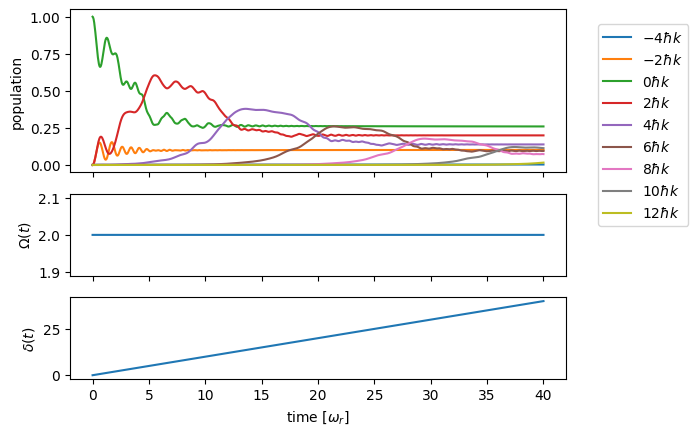

In [2]:
from mwave.integrate import bloch, make_kvec, make_phi
from numba import jit
import numpy as np
from matplotlib import pyplot as plt

# Define pulse parameters
n0, nf = 0, 5
omega = 2
alpha = 1
Gamma_sps = 0.5

# Compute parameters
delta0 = 8*n0
deltaf = 8*nf
tfinal = (deltaf-delta0)/alpha

# Define a constant pulse profile
@jit(nopython=True)
def omega_fnc(t, args):
    omega = args[0]
    return omega

# Define a quadratically ramped phase
@jit(nopython=True)
def phase_fnc(t, args):
    return delta0*t+0.5*alpha*t**2 # The phase is the integral of the time dependent frequency over time

# Write out a function for the detuning vs time
def delta_fnc(t):
    return delta0+alpha*t

# Define the initial state and the kvec array
kvec, n0_idx, nf_idx = make_kvec(n0, nf)
phi0 = make_phi(kvec, n0)

# Integrate the pulse
sol = bloch(kvec, phi0, tfinal, 0, omega_fnc, np.array([omega]), phase_fnc, np.array([]), Gamma_sps=Gamma_sps)
pops = np.diagonal(sol.y)

# Determine the minimum and maximum indicies
n_max = max(n0_idx, nf_idx)
n_min = min(n0_idx, nf_idx)

# Plot
fig, [ax1, ax2, ax3] = plt.subplots(nrows = 3, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
ax1.plot(sol.t, np.real(pops[:,n_min-2:n_max+2]), label=[r"$%i\hbar k$" % k for k in kvec[n_min-2:n_max+2]])
ax2.plot(sol.t, [omega_fnc(t, np.array([omega])) for t in sol.t])
ax3.plot(sol.t, [delta_fnc(t) for t in sol.t])
ax1.legend(bbox_to_anchor=(1.05, 0.95))
ax1.set_ylabel(r'population')
ax2.set_ylabel(r'$\Omega(t)$')
ax3.set_ylabel(r'$\delta(t)$')
ax3.set_xlabel(r'time [$\omega_r$]')
plt.show()